# Distribution of branch lengths conditioned on selection on a derived variant

In [1]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

Indlæser krævet pakke: viridisLite



R header:

In [2]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
devtools::install_github("TobiasRoikjer/PtDAlgorithms")
library(ptdalgorithms)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis

Skipping install of 'ptdalgorithms' from a github remote, the SHA1 (dfc78fe3) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
# remove.packages("ptdalgorithms")

In [4]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [5]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [6]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [7]:
Rcpp::sourceCpp("./coalescent.cpp")

In [8]:
source("plot_functions.R")

In [9]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(family="Arial"))

In [10]:
# p <- ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
#       geom_point(aes(color=Species, shape=Species)) + despine

# ggplotly(width=600, height=400)

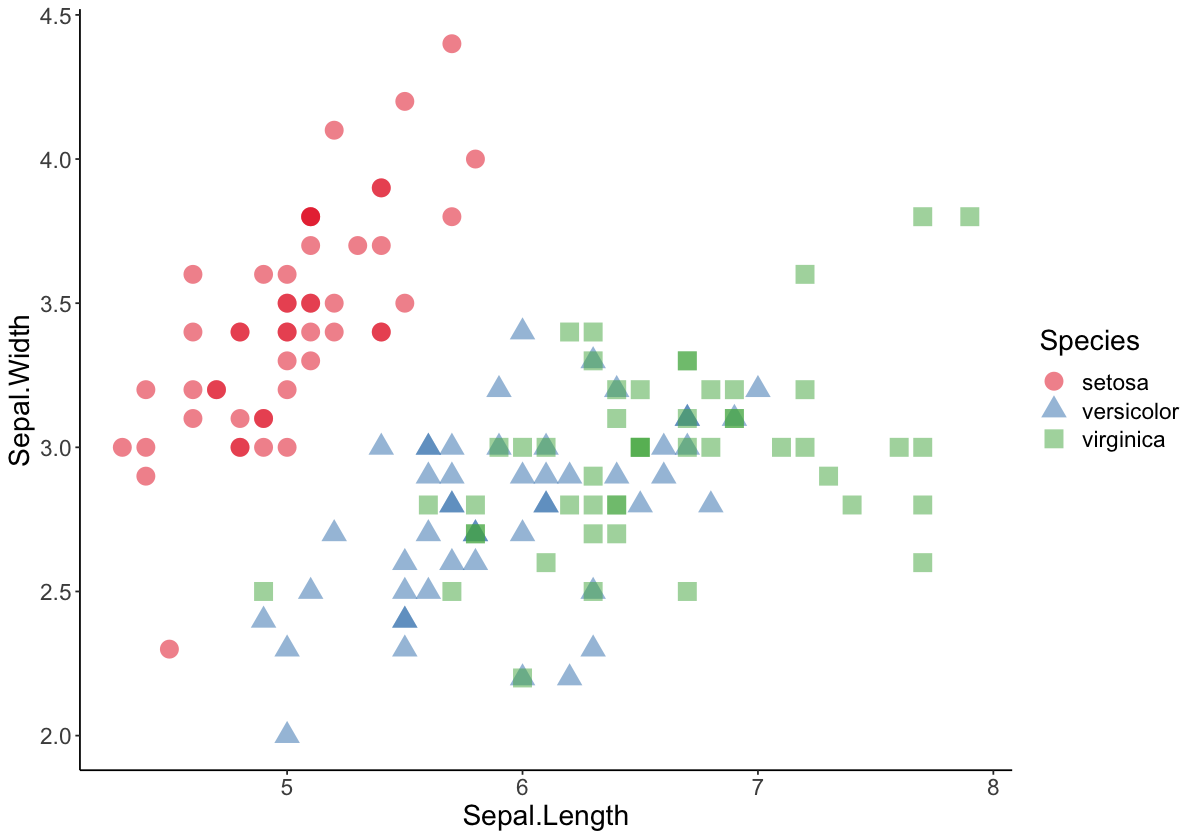

In [11]:
despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                text=element_text(size=17)) 

options(repr.plot.width=10, repr.plot.height=7)

ggplot(data=iris, aes(x = Sepal.Length, y = Sepal.Width)) +
      geom_point(aes(color=Species, shape=Species), size=5, alpha=0.5) + scale_color_brewer(palette="Set1") + despine

## Utility functions

In [144]:
state_legend <- function(graph) {

    mat <- graph_as_matrix(graph)

    cat('state\t\t\ttons (anc/der)\t\tfreq bin', '\n')
    
    cat('\t\t', paste(seq(1:(sample_size-1)), collapse='\t'), '\n', sep='\t')
    
    for (s in 1:nrow(mat$states)) {
        nr_anc_tons <- integer(sample_size-1)
        nr_der_tons <- integer(sample_size-1)
        for (i in 1:ncol(mat$states)) {
            props <- index_to_props(sample_size, i)
            if (props$n_descendants > 0) {
                if (props$is_derived == 1) {
                    nr_der_tons[props$n_descendants] <- mat$states[s, i] + nr_der_tons[props$n_descendants]
                } else {
                    nr_anc_tons[props$n_descendants] <- mat$states[s, i] + nr_anc_tons[props$n_descendants]
                }
            }
        }
        cat(paste(mat$states[s, ], collapse=','), '\t')
        for (i in 1:(sample_size-1)) {
            cat(nr_der_tons[i], "/", nr_anc_tons[i], sep='')
            cat('\t')
        }
        cat(mat$states[s, length(mat$states[s, ])])
        cat('\n')
    }
}

In [51]:
# plot_sfs <- function(graph, rewards, n) {
#     sfs <- sapply(1:(dim(rewards)[1]-1), function(i) expectation(graph, rewards[i,]))
#     data.frame(
#       ton=seq(1,length(sfs)),  
#       brlen=sfs
#       ) %>% ggplot(aes(x=ton, y=brlen, fill=ton)) + 
#       geom_bar(stat = "identity", width=0.8) + scale_fill_viridis() + 
#       despine
# }

# plot_sfs_dph <- function(graph, rewards, trunc=4) {
#     result = data.frame()
#     for (i in 1:(nrow(rewards)-1)) {
#         x <- seq(from = 0, to = trunc, by = 0.01)
#         pdf <- dph(x, reward_transform(graph, rewards[i, ]))
#         df <- data.frame(prob = pdf, t=x, ton=i)
#         result <- rbind(result, df)
#     }
#     result %>% ggplot(aes(y=prob, x=t, group=ton, color=ton)) +
#         geom_line(linewidth=1) + scale_color_viridis() + despine
# }
                               
get_cov_mat <- function(graph, rewards) {
    n <- nrow(rewards)
    cov_mat <- matrix(nrow=n-1,ncol=n-1)
    for (i in 1:(n-1)) {
        for (j in 1:(n-1)) {
            cov_mat[i, j] <- covariance(graph, rewards[i,], rewards[j,])
        }
    }
    return(cov_mat)
}
                  
plot_cov_mat <- function(cov_mat) {
   
    df <- as.data.frame(cov_mat)
    df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
    
    ggplot(df, aes(ton1, ton2)) +
        geom_tile(aes(fill = value)) + 
        scale_y_discrete(labels= seq(1, nrow(cov_mat))) + 
        scale_fill_continuous(type = "viridis") + 
        theme_minimal() + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 

}


plot_graph <- function(gam, constrained=TRUE, subgraphs=FALSE, size=c(6, 6), fontsize=10, rankdir="LR") {


    format_rate <- function(rate) {
        # tol = .Machine$double.eps^0.5
        # if (min(abs(c(rate%%1, rate%%1-1))) < tol) {
        if (rate == round(rate)) {
            return(rate)
        } else {
            return(formatC(rate, format = "e", digits = 2))
        }
    }

    sub_graph <- function(state) state[length(state)]
    sub_graphs = list()
    
    if (constrained) {
        constrained <- 'true'
    } else {
        constrained <- 'false'
    }

    edge_templ <- '"FROM" -> "TO" [constraint=true, label="LABEL",labelfloat=false];'
    subgraph_template <- '
    subgraph cluster_FREQBIN {
        style=filled;
        color=lightgrey;
        node [style=filled,color=white];
        NODES;
        label = "Freqbin FREQBIN";
    }
    '
    start_name <- 'IPV'
    absorbing_name <- 'Absorb'
    edges <- c()
    # IPV edges
    for (i in 1:length(gam$IPV)) {
        if (gam$IPV[i] > 0) {
            edge <- edge_templ
            edge <- sub('FROM', start_name, edge)
            edge <- sub('TO', paste(gam$states[i,], collapse = ","), edge)
            edge <- sub('LABEL', gam$IPV[i], edge)
            edges <- c(edges, edge)
        }
    }    
    # Matrix edges
    for (i in 1:(nrow(gam$states))) {
        for (j in 1:nrow(gam$states)) {
            if ((i != j) && (gam$SIM[i, j] > 0)) {
                edge <- edge_templ
                edge <- sub('FROM', paste(gam$states[i,], collapse = ","), edge)
                edge <- sub('TO', paste(gam$states[j,], collapse = ","), edge)
                edge <- sub('LABEL', format_rate(gam$SIM[i, j]), edge)
                edges <- c(edges, edge)
            }
        }
    }

    absorb_rates <- -rowSums(gam$SIM)
    for (i in 1:nrow(gam$states)) {
        if (absorb_rates[i] > 0) {
            # edges <- c(edges, paste('"', from, '"', ' -> ', 'Absorb', '[constraint=true, label="', label, '",labelfloat=false]', ';', sep='')) 
            edge <- edge_templ
            edge <- sub('FROM', paste(gam$states[i,], collapse = ","), edge)
            edge <- sub('TO', absorbing_name, edge)
            edge <- sub('LABEL', absorb_rates[i], edge)
            edges <- c(edges, edge)
        }
    }

    graph_spec <- paste(edges, collapse = '\n')

    if (subgraphs) {
        for (i in 1:(nrow(gam$states))) {
            sg <- as.character(sub_graph(gam$states[i,]))
            sub_graphs[[sg]] <- c(sub_graphs[[sg]], paste(gam$states[i,], collapse = ","))
        }
        for (sg in labels(sub_graphs)) {
            nodes <- sub_graphs[[sg]]
            tmpl <- subgraph_template
            node_str <- ''
            for (i in 1:length(nodes)) {
                node_str <- paste(node_str, paste('"', nodes[i], '" ', sep=''), sep=' ')
            }
            tmpl <- sub('NODES', node_str, tmpl)
            tmpl <- sub('FREQBIN', sg, tmpl)            
            tmpl <- sub('FREQBIN', sg, tmpl)            
            graph_spec <- paste(graph_spec, tmpl)
        }
    }

# https://graphviz.org/Gallery/directed/cluster.html
    
    style_str <- '
        rankdir=RANKDIR;
        size="SIZEX,SIZEY";
        fontname="Helvetica,Arial,sans-serif"
    	node [fontname="Helvetica,Arial,sans-serif", fontsize=FONTSIZE]
    	edge [fontname="Helvetica,Arial,sans-serif", fontsize=FONTSIZE]
        Absorb [style=filled,color="lightgrey"]
        IPV [style=filled,color="lightgrey"]
    '
    style_str <- sub('SIZEX', size[1], style_str)
    style_str <- sub('SIZEY', size[2], style_str)
    style_str <- gsub('FONTSIZE', fontsize, style_str)    
    style_str <- gsub('RANKDIR', rankdir, style_str)    
    graph_string <- paste('digraph G {', style_str, graph_spec, '}', sep='\n')
    system("dot -Tsvg -o tmp.svg", input=graph_string, intern=TRUE)
    return(display_svg(file="tmp.svg"))
    }

In [17]:
# plot_graph <- function(gam, constrained=TRUE, size=c(6, 6), fontsize=10, rankdir="LR") {

#     if (constrained) {
#         constrained <- 'true'
#     } else {
#         constrained <- 'false'
#     }

#     edge_templ <- '"FROM" -> "TO" [constraint=true, label="LABEL",labelfloat=false];'
#     start_name <- 'IPV'
#     absorbing_name <- 'Absorb'
#     edges <- c()
#     for (i in 1:length(gam$IPV)) {
#         if (gam$IPV[i] > 0) {
#             edge <- edge_templ
#             edge <- sub('FROM', start_name, edge)
#             edge <- sub('TO', paste(gam$states[i,], collapse = ","), edge)
#             edge <- sub('LABEL', gam$SIM[i, j], edge)
#             edges <- c(edges, edge)
#         }
#     }    
#     for (i in 1:nrow(gam$states)) {
#         for (j in 1:nrow(gam$states)) {
#             if ((i != j) && (gam$SIM[i, j] > 0)) {
#                 edge <- edge_templ
#                 edge <- sub('FROM', paste(gam$states[i,], collapse = ","), edge)
#                 edge <- sub('TO', paste(gam$states[j,], collapse = ","), edge)
#                 edge <- sub('LABEL', gam$SIM[i, j], edge)
#                 edges <- c(edges, edge)
#             }
#         }
#     }
#     absorb_rates <- -rowSums(gam$SIM)
#     for (i in 1:nrow(gam$states)) {
#         if (absorb_rates[i] > 0) {
#             # edges <- c(edges, paste('"', from, '"', ' -> ', 'Absorb', '[constraint=true, label="', label, '",labelfloat=false]', ';', sep='')) 
#             edge <- edge_templ
#             edge <- sub('FROM', paste(gam$states[i,], collapse = ","), edge)
#             edge <- sub('TO', absorbing_name, edge)
#             edge <- sub('LABEL', absorb_rates[i], edge)
#             edges <- c(edges, edge)
#         }
#     }
#     graph_spec <- paste(edges, sep='\n', collapse = '')
#     style_str <- '
#         rankdir=RANKDIR;
#         size="SIZEX,SIZEY";
#         fontname="Helvetica,Arial,sans-serif"
#     	node [fontname="Helvetica,Arial,sans-serif", fontsize=FONTSIZE]
#     	edge [fontname="Helvetica,Arial,sans-serif", fontsize=FONTSIZE]
#         Absorb [style=filled,color="lightgrey"]
#         IPV [style=filled,color="lightgrey"]
#     '
#     style_str <- sub('SIZEX', size[1], style_str)
#     style_str <- sub('SIZEY', size[2], style_str)
#     style_str <- gsub('FONTSIZE', fontsize, style_str)    
#     style_str <- gsub('RANKDIR', rankdir, style_str)    
#     graph_string <- paste('digraph G {', style_str, graph_spec, '}', sep='\n')
#     system("dot -Tsvg -o tmp.svg", input=graph_string, intern=TRUE)
#     return(display_svg(file="tmp.svg"))
#     }
# plot_graph(gam, rankdir="LR")

## Coalescent with selection

In [118]:
Rcpp::sourceCpp("./coalescent.cpp")

In [138]:
sample_size <- 3
n_derived <- 0
pop_size <- 100
n_freqbins <- 3
sel_coef <- 0

graph <- construct_coalescent_selection_graph(sample_size, n_derived, pop_size, n_freqbins, sel_coef)
vertices_length(graph)

[1] 10

In [139]:
expectation(graph)

[1] 1.333333

With `sample_size = 4`, `n_derived = 2`, and `sel_coef = 0`, the probability that the two drived coalesce first it $\frac{1}{2}$.

$$
    t_{TMRCA} =
\begin{cases}
    \frac{1}{6}+\frac{1}{3}+1, & \text{if } p < \frac{1}{2} \mbox{derived coal. first} \\
    \frac{1}{6}+\frac{1}{2}+1              & \text{otherwise}
\end{cases}
$$

So the TMRCA should be: $ \frac{1}{2} \big(\frac{1}{6}+\frac{1}{3}+1\big) + \frac{1}{2}\big(\frac{1}{6}+\frac{1}{2}+1\big) = 1 \frac{2}{3}$

State index legend:

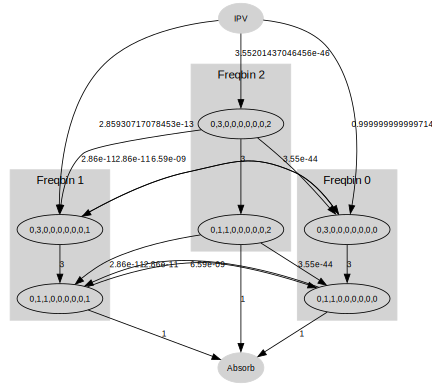

In [145]:
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, size=c(6, 6), rankdir="TB")
#plot_graph(gam, subgraphs=TRUE, size=c(8, 8))

In [146]:
state_legend(graph)

state			tons (anc/der)		freq bin 
			1	2	
0,3,0,0,0,0,0,0,2 	0/3	0/0	2
0,3,0,0,0,0,0,0,1 	0/3	0/0	1
0,3,0,0,0,0,0,0,0 	0/3	0/0	0
0,1,1,0,0,0,0,0,2 	0/1	0/1	2
0,1,1,0,0,0,0,0,0 	0/1	0/1	0
0,1,1,0,0,0,0,0,1 	0/1	0/1	1


In [27]:
expectation(graph)

[1] 1.542594

In [28]:
gam <- graph_as_matrix(graph)
gam

$states
      [,1] [,2] [,3] [,4] [,5] [,6] [,7] [,8] [,9] [,10] [,11]
 [1,]    0    2    0    0    0    0    2    0    0     0     1
 [2,]    0    2    0    0    0    0    2    0    0     0     0
 [3,]    0    0    1    0    0    0    2    0    0     0     0
 [4,]    0    0    1    0    0    0    2    0    0     0     1
 [5,]    0    2    0    0    0    0    0    1    0     0     0
 [6,]    0    2    0    0    0    0    0    1    0     0     1
 [7,]    0    0    1    0    0    0    0    1    0     0     1
 [8,]    0    0    1    0    0    0    0    1    0     0     0
 [9,]    0    1    0    1    0    0    0    0    0     0     1
[10,]    0    1    0    1    0    0    0    0    0     0     0

$SIM
           [,1]      [,2]        [,3]      [,4] [,5]        [,6]        [,7]
 [1,] -105.3333  100.0000    0.000000    4.0000    0    1.333333    0.000000
 [2,]  100.0000 -105.3333    1.333333    0.0000    4    0.000000    0.000000
 [3,]    0.0000    0.0000 -104.000000  100.0000    0    0.000000    0.000000
 [4,]    0.0000    0.0000  100.000000 -101.3333    0    0.000000    1.333333
 [5,]    0.0000    0.0000    0.000000    0.0000 -103  100.000000    0.000000
 [6,]    0.0000    0.0000    0.000000    0.0000  100 -103.000000    1.000000
 [7,]    0.0000    0.0000    0.000000    0.0000    0    0.000000 -101.000000
 [8,]    0.0000    0.0000    0.000000    0.0000    0    0.000000  100.000000
 [9,]    0.0000    0.0000    0.000000    0.0000    0    0.000000    0.000000
[10,]    0.0000    0.0000    0.000000    0.0000    0    0.000000    0.000000
      [,8] [,9] [,10]
 [1,]    0    0     0
 [2,]    0    0     0
 [3,]    4    0     0
 [4,]    0    0     0
 [5,]    1    0     2
 [6,]    0    2     0
 [7,]  100    0     0
 [8,] -101    0     0
 [9,]    0 -101   100
[10,]    0  100  -101

$IPV
 [1] 1.392956e-24 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 [6] 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00

$indices
 [1]  3  2  4  6  5  7 10  8 11  9

In [41]:
x <- gam$IPV / sum(gam$IPV)

## Standard coalescent

If you already have the subintensity matrix and initial probability vector:

In [26]:
sim = matrix(c(-6, 6, 0, 0, 
               0, -3, 1, 2,
               0, 0, -1, 0,
               0, 0, 0, -1), nrow=4, ncol=4, byrow = TRUE)
ipv = c(1, 0, 0, 0)
sim

-6,6,0,0
0,-3,1,2
0,0,-1,0
0,0,0,-1


In [27]:
graph <- matrix_as_graph(ipv, sim)

**NB:** the state vectors are ofcause undefined (all zero) when constructing the graph this way:

In [28]:
gam <- graph_as_matrix(graph)
gam

$states
     [,1]
[1,]    0
[2,]    0
[3,]    0
[4,]    0

$SIM
     [,1] [,2] [,3] [,4]
[1,]   -6    6    0    0
[2,]    0   -3    1    2
[3,]    0    0   -1    0
[4,]    0    0    0   -1

$IPV
[1] 1 0 0 0

$indices
[1] 2 3 4 5

In [29]:
dph(0.9, graph)

[1] 0.5362689

If you want to generate the state space:

In [30]:
n <- 4
  
state_vector_length <- n
graph <- create_graph(state_vector_length)
starting_vertex <- vertex_at(graph, 1)
initial_state <- rep(0, n)
initial_state[1] <- n

add_edge(
  starting_vertex,
  create_vertex(graph, initial_state),
  1
)
index <- 2

while (index <= vertices_length(graph)) {
  vertex <- vertex_at(graph, index)
  
  # loop over all classes of lineages
  for (i in 1:n) {
    for (j in i:n) {
      state <- vertex$state
      
      # if same class, there need to be at least two to coalesce
      if (i == j) {
        if (state[i] < 2) {
          next;
        }
        # coal rate
        rate <- state[i] * (state[i] - 1) / 2
      } else {
        # else at least one in each class to coalesce
        if (state[i] < 1 || state[j] < 1) {
          next;
        }
        # number of combinations
        rate <- state[i] * state[j]
      }
      
      # copy state
      child_state <- state
      # update child state
      child_state[i] <- child_state[i] - 1
      child_state[j] <- child_state[j] - 1
      child_state[i+j] <- child_state[i+j] + 1
      
      add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          rate, c(rate)
        )
    }
  }
      
  index <- index + 1
}

# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM

gam <- graph_as_matrix(graph)
vertices_length(graph)

[1] 6

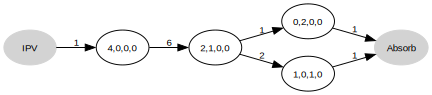

In [34]:
plot_graph(gam)

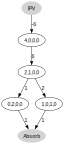

In [43]:
plot_graph(gam, rankdir="TB", fontsize=14, size=c(2, 2))

As matrices:

In [44]:
matrices <- graph_as_matrix(graph)
states <- matrices$states
sim <- matrices$SIM
matrices

4,0,0,0
2,1,0,0
0,2,0,0
1,0,1,0
-6,6,0,0
0,-3,1,2
0,0,-1,0
0,0,0,-1


Invert subintensity matrix to get Green matrix:

In [45]:
U <- -solve(matrices$SIM)
U

0.1666667,0.3333333,0.3333333,0.6666667
0.0000000,0.3333333,0.3333333,0.6666667
0.0000000,0.0000000,1.0000000,0.0000000
0.0000000,0.0000000,0.0000000,1.0000000


Compute expectation from matrices:

In [46]:
matrices$IPV %*% U %*% rep(1, length(matrices$IPV))

1.5


Compute moments:

In [47]:
expectation(graph)

[1] 1.5

In [48]:
expected_waiting_time(graph)

[1] 1.500000 1.500000 1.333333 1.000000 1.000000 0.000000

In [33]:
variance(graph)

[1] 1.138889

In [34]:
2 * expected_waiting_time(graph, expected_waiting_time(graph)) - expected_waiting_time(graph) * expected_waiting_time(graph)

[1] 1.138889 1.138889 1.111111 1.000000 1.000000 0.000000

Or computed from the second moment:

In [35]:
exp_wait_1nd_moment = expected_waiting_time(graph)
exp_wait_1nd_moment

[1] 1.500000 1.500000 1.333333 1.000000 1.000000 0.000000

In [36]:
exp_wait_2nd_moment = expected_waiting_time(graph, exp_wait_1nd_moment)
exp_wait_2nd_moment

[1] 1.694444 1.694444 1.444444 1.000000 1.000000 0.000000

In [37]:
(2 * exp_wait_2nd_moment - exp_wait_1nd_moment**2)[1]


[1] 1.138889

In [38]:
(2 * expected_waiting_time(graph, expected_waiting_time(graph)) - expected_waiting_time(graph) * expected_waiting_time(graph))[1]

[1] 1.138889

Four moments:

In [39]:
moments(graph, 4)

[1]  1.500000  3.388889 10.583333 42.907407

Marginal expectations using rewards:

In [40]:
state_matrix <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
state_matrix

0,4,2,0,1,0
0,0,1,2,0,0
0,0,0,0,1,0
0,0,0,0,0,1


Rows happens to be our reward vectors. E.g. singleton rewards:

In [41]:
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )
singletons <- rewards[1,]
doubletons <- rewards[2,]
tripletons <- rewards[3,]
singletons

[1] 0 4 2 0 1 0

Expected tripleton branch length:

In [42]:
expectation(graph, tripletons)

[1] 0.6666667

SFS:

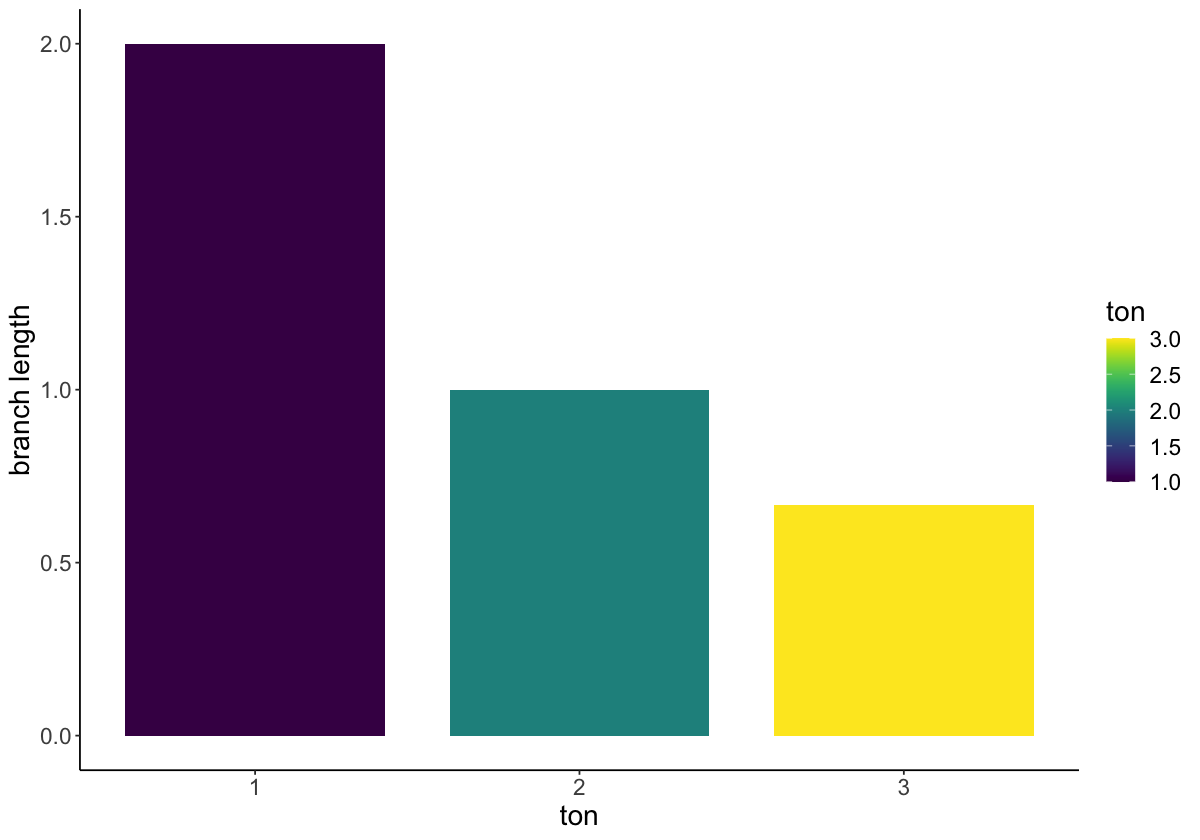

In [45]:
plot_sfs(graph, rewards) + labs(y = "branch length", x = "ton") 

In [46]:
# sns.barplot(x=list(range(1, len(sfs)+1)), y=sfs)
# sns.despine()

Covariance:

In [47]:
covariance(graph, singletons, doubletons)

[1] -0.2222222

In [48]:
covariance(graph, singletons, tripletons)

[1] 0.8888889

Covariane between "ton" branch length:

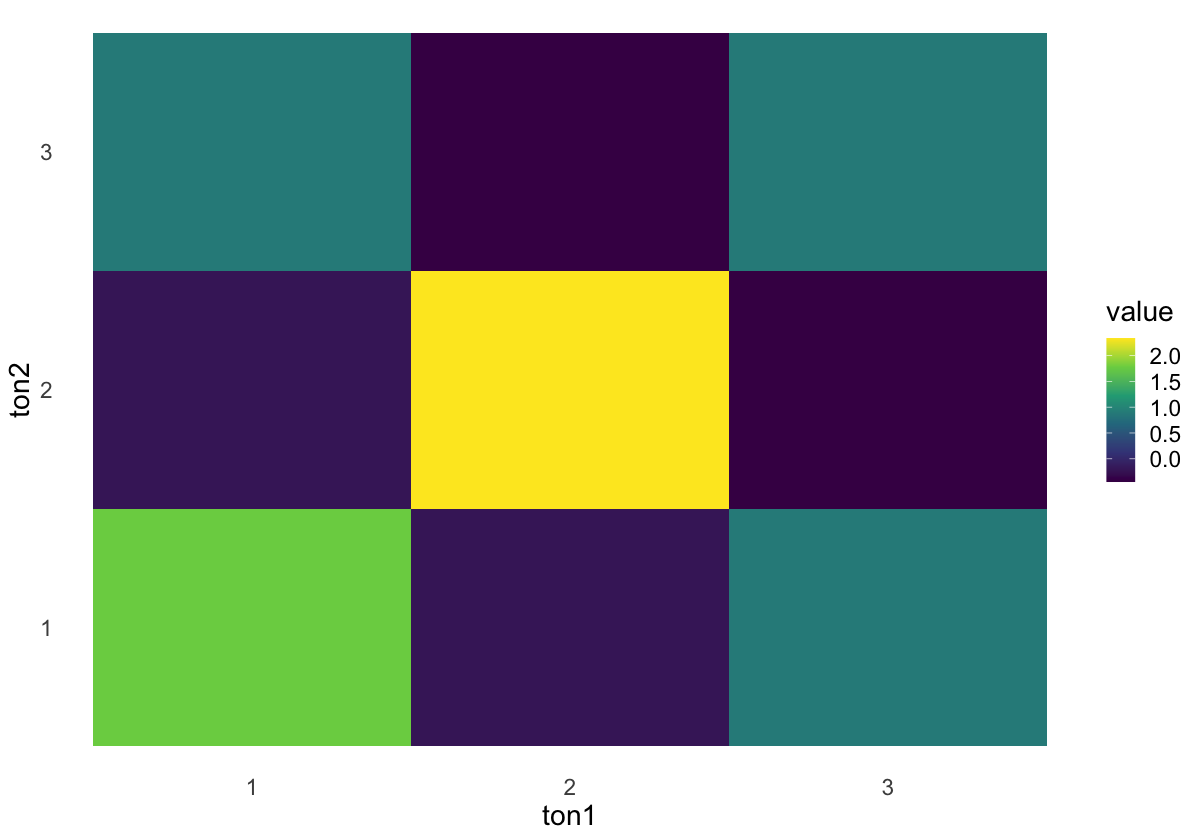

In [49]:
plot_cov_mat(get_cov_mat(graph, rewards))

Distributions of each "ton" branch length:

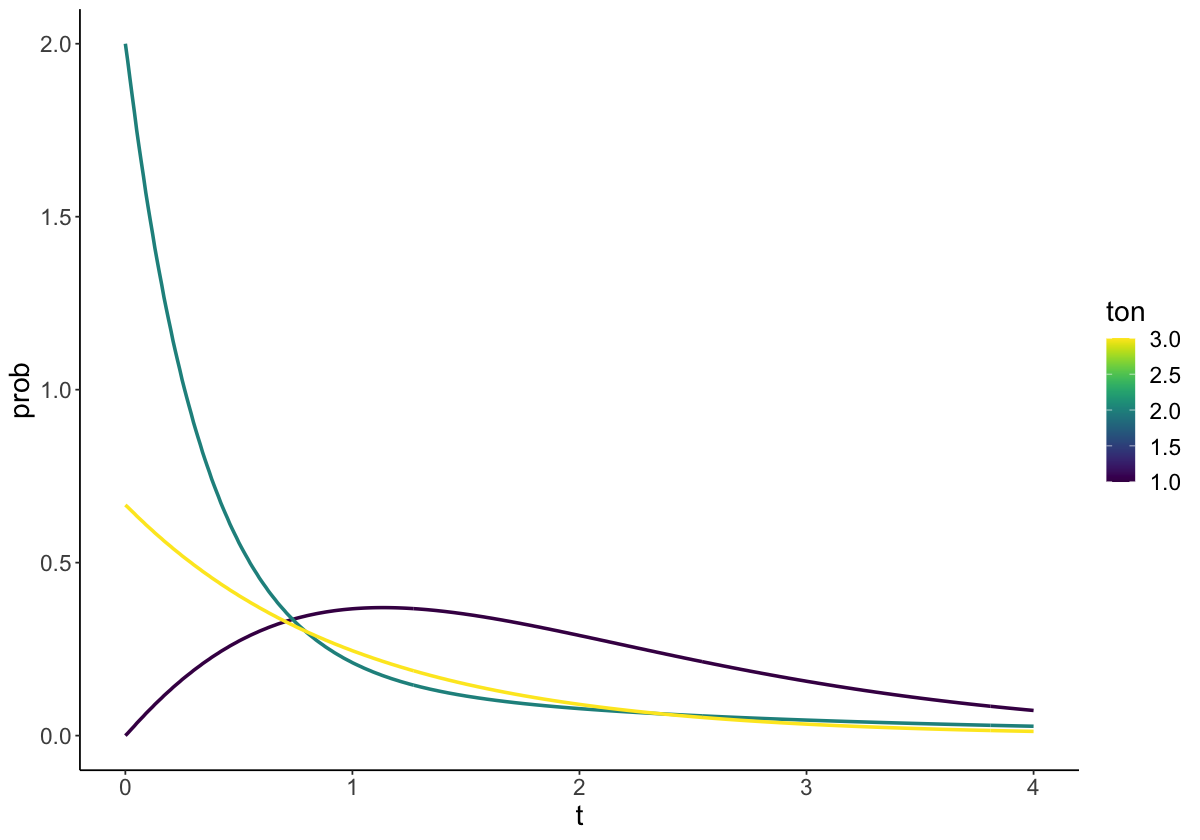

In [50]:
source("plot_functions.R")
plot_sfs_dph(graph, rewards)

Compute expectations from the distributions:

In [51]:
ctx <- distribution_context(graph,1000)
prev_size <- 0
while (distribution_context_state(ctx)$cdf < 0.999) { 
    distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)
sfs <- sapply(1:(dim(rewards)[1]-1), function(i) sum(expected_visits * rewards[i,]))

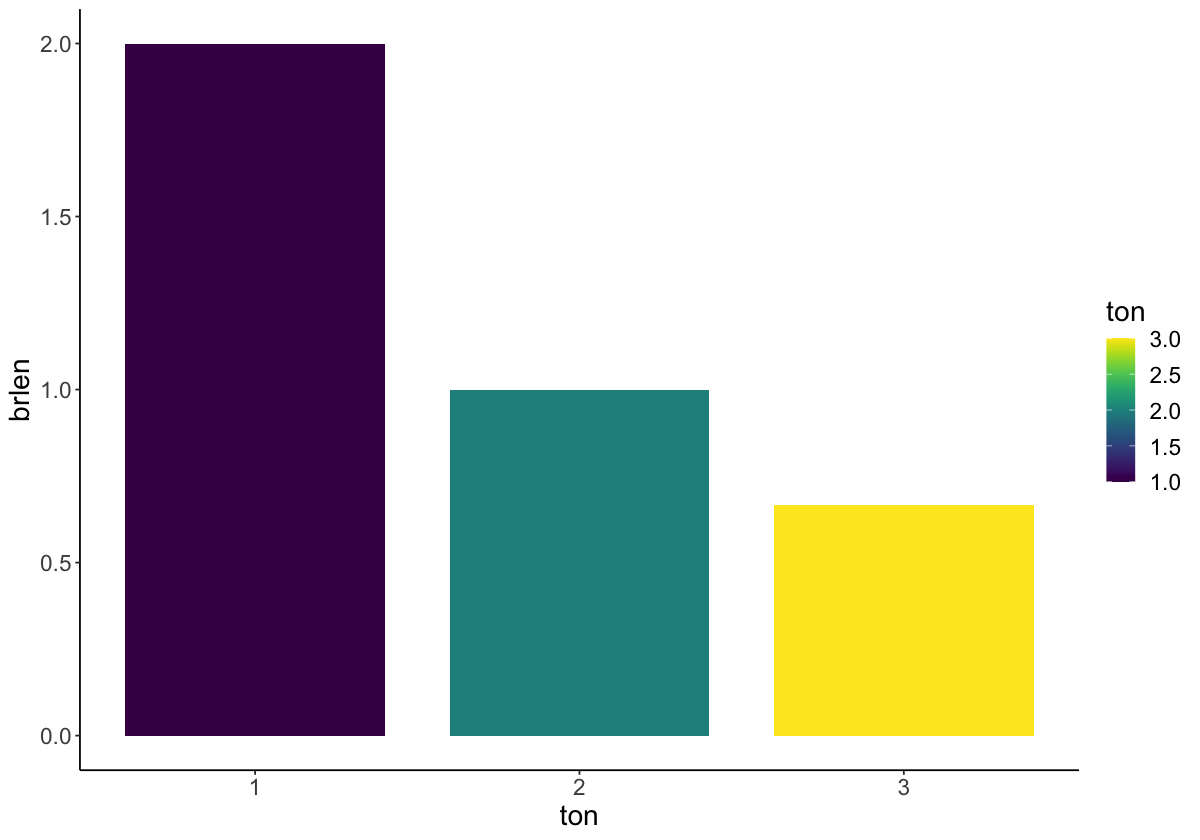

In [52]:
data.frame(ton=seq(1,length(sfs)), brlen=sfs) %>%
ggplot(aes(x=ton, y=brlen, fill=ton)) + 
  geom_bar(stat = "identity", width=0.8) + scale_fill_viridis() + despine

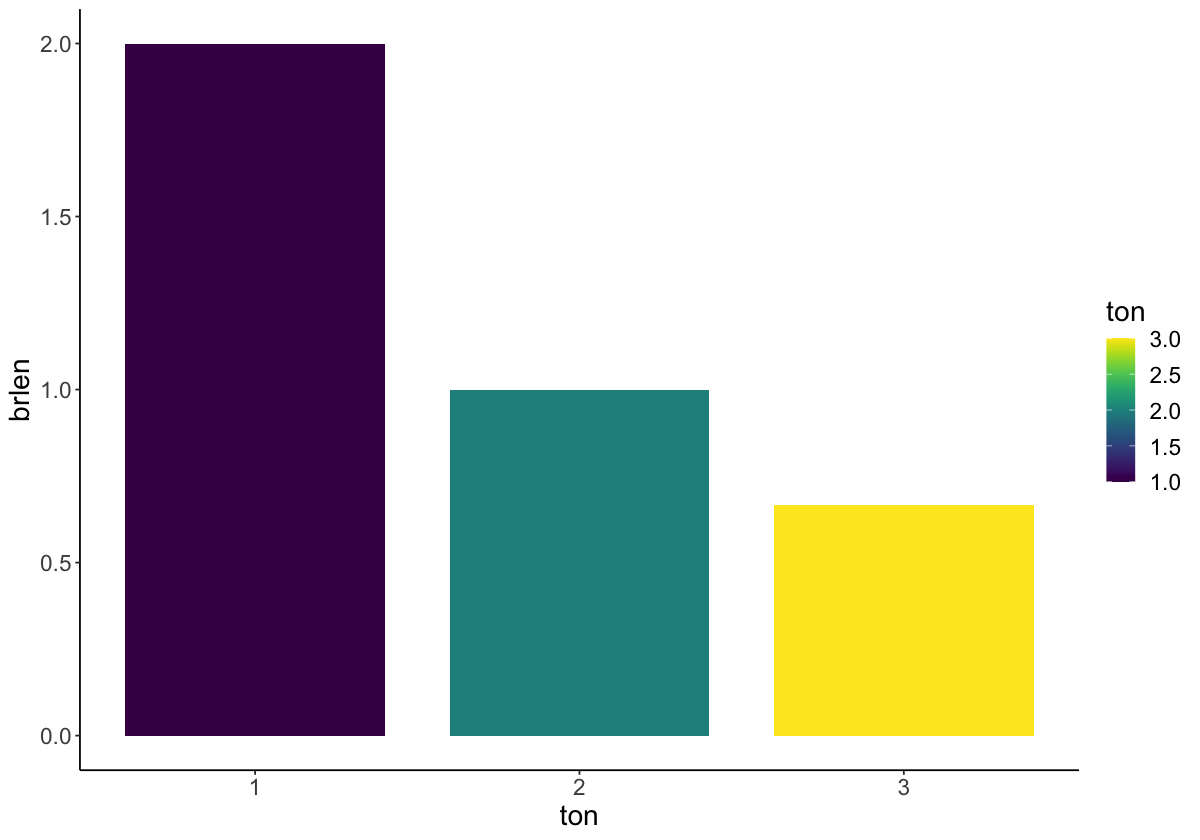

In [53]:
data <- data.frame(ton=seq(1,length(sfs)), brlen=sfs)
ggplot(data, aes(x=ton, y=brlen, fill=ton)) + 
  geom_bar(stat = "identity", width=0.8) + scale_fill_viridis() + despine

Changing rates (edge weights) using parametrization:

In [54]:
graph_update_weights_parameterized(graph, c(2))

# states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
# ipv <- graph_as_matrix(graph)$IPV
# sim <- graph_as_matrix(graph)$SIM
gam <- graph_as_matrix(graph)

Change rates back to normal:

In [55]:
#plot_graph(gam)

In [56]:
graph_update_weights_parameterized(graph, c(1))

states <- t(sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state ))
ipv <- graph_as_matrix(graph)$IPV
sim <- graph_as_matrix(graph)$SIM

In [57]:
#plot_graph(gam)

## Distribution over states at accross time

In [58]:
t <- seq(from = 0, to = 5, by = 0.01)
fun <- function(t) {
    x <- stop_probability(graph, t)
    return(x[2:(length(x)-1)])
}
df <- as.data.frame(t(sapply(t, fun))) 
df['time'] <- t
head(df)

,V1,V2,V3,V4,time
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.0000000,0.00000000,0.0000000000,0.0000000000,0.00
2,0.9374023,0.06167808,0.0003056227,0.0006112454,0.01
3,0.8839023,0.11268746,0.0011296433,0.0022592865,0.02
4,0.8334556,0.15920896,0.0024216864,0.0048433728,0.03
5,0.7858880,0.20154429,0.0041349045,0.0082698089,0.04
6,0.7366933,0.24361558,0.0064540291,0.0129080582,0.05


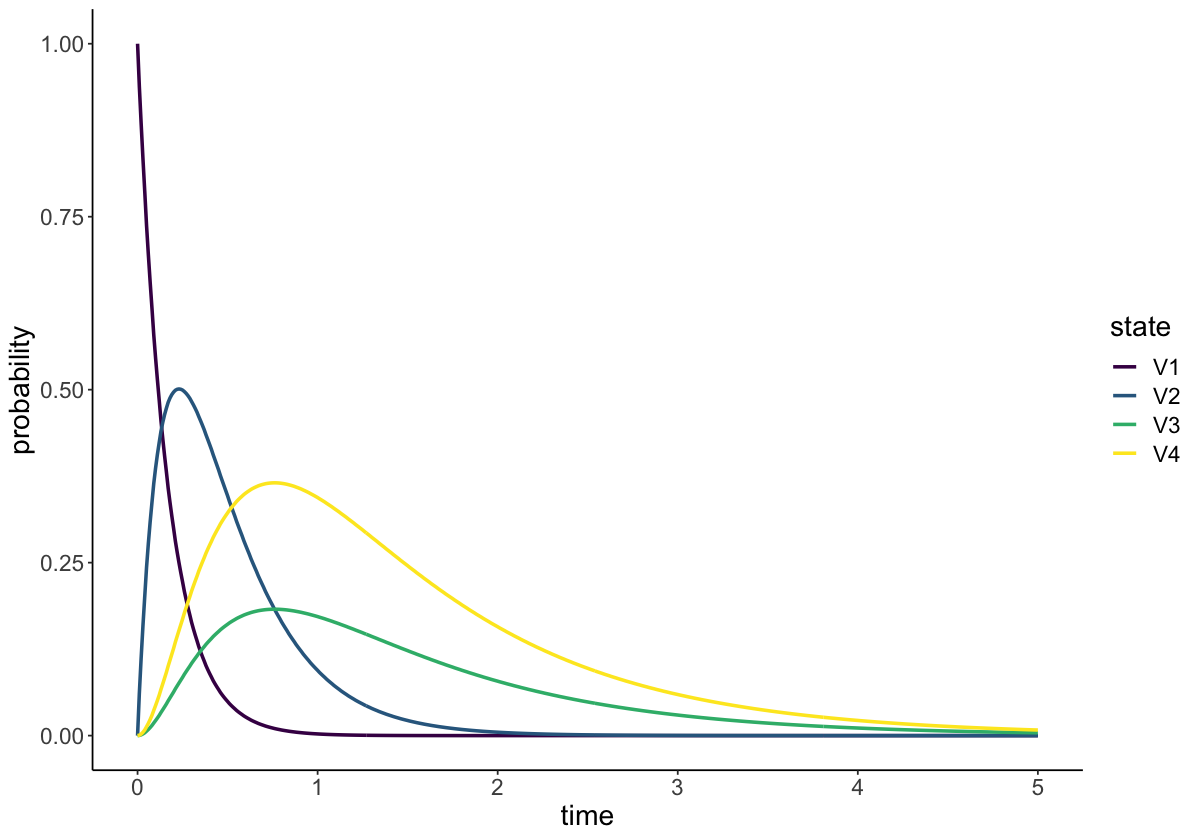

In [59]:
df %>% gather(state, probability, -time) %>% ggplot(aes(y=probability, x=time, group=state, color=state)) +
        geom_line(linewidth=1) + scale_color_viridis(discrete=TRUE) + despine

**Convolution howto:**

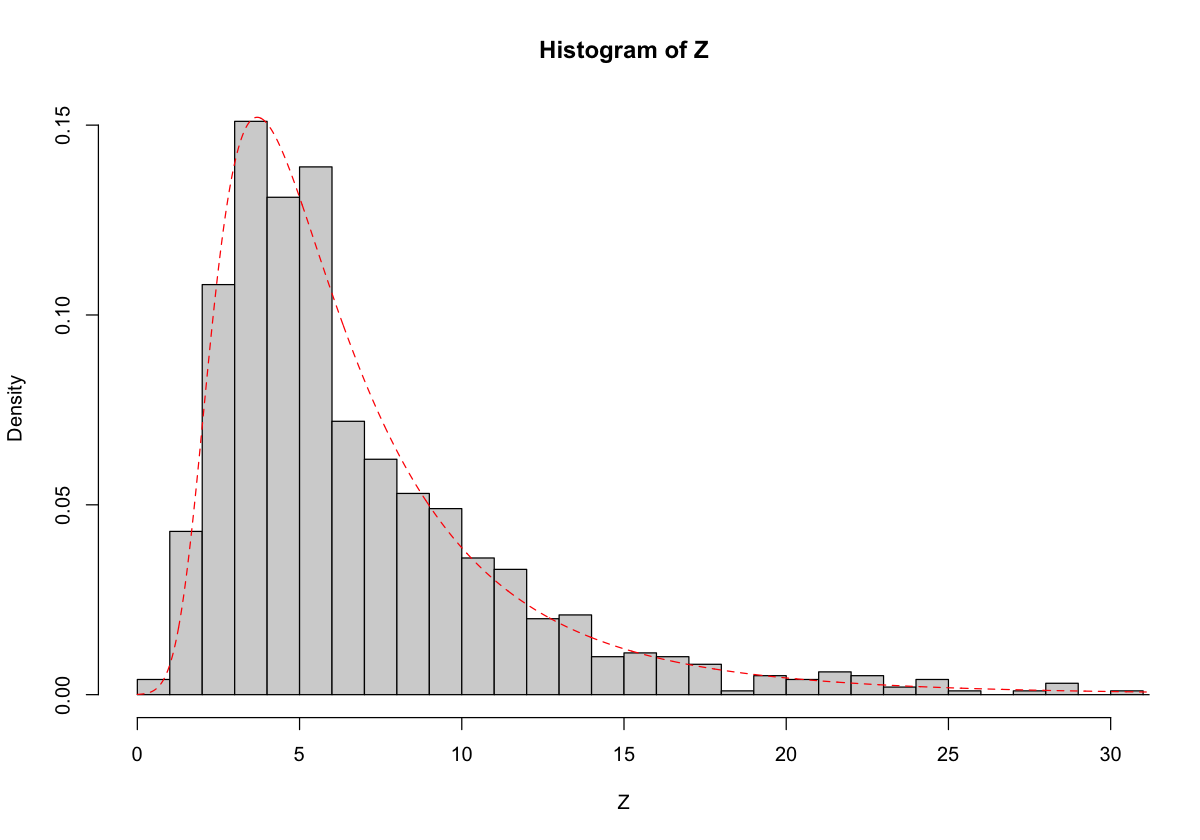

In [82]:
f.X <- function(x) dnorm(x,1,0.5)        # normal (mu=1.5, sigma=0.5)
f.Y <- function(y) dlnorm(y,1.5, 0.75)   # log-normal (mu=1.5, sigma=0.75)
# convolution integral
integrand <- function(x, z) f.Y(z-x)*f.X(x)
f.Z <- function(z) integrate(integrand,-Inf,Inf,z)$value
f.Z <- Vectorize(f.Z) 
                             
set.seed(1)                              # for reproducible example
X <- rnorm(1000,1,0.5)
Y <- rlnorm(1000,1.5,0.75)
Z <- X + Y
# compare the methods
hist(Z,freq=F,breaks=50, xlim=c(0,30))
z <- seq(0,50,0.01)
lines(z,f.Z(z),lty=2,col="red")                    

## Time-inhomgeneous coalescent

The distribution context is always made on the graph without rewards transformation. You can then:

- Get the distribution (and from that all moments) of time to absorbtion. Note that you cannot use dph for this as this assumes the current edge-weights and not seqentially updated ones in the distribution context.
- Get the marginal expectations by summing over the products of the expected accumulated visiting times and rewards.


In [90]:
cdf_timeinhom <- function(graph, eqopues, sizes) {

    tmrca_pdf <- c()
    time <- c()
    
    ctx <- distribution_context(graph, 1000)
    prev_size <- 0
    while (distribution_context_state(ctx)$cdf < 0.999) { 
        tmrca_pdf[[(length(tmrca_pdf) + 1)]] <- distribution_context_state(ctx)$cdf
        time[[(length(time) + 1)]] <- distribution_context_state(ctx)$time
        
        size <- sizes[findInterval(distribution_context_state(ctx)$time, epoques)]
        if (size != prev_size) {
            graph_update_weights_parameterized(graph, c(1/size))
        }
        prev_size <- size
        distribution_context_step(ctx)        
    }

    return(data.frame(prob = unlist(tmrca_pdf), t=unlist(time)))

}

epoques = c(0, 1, 2, 3, 4)
cdf1 <- cdf_timeinhom(graph, epoques, c(1, 1, 1, 1, 1))
cdf2 <- cdf_timeinhom(graph, epoques, c(1, 2, 4, 8, 16))
cdf3 <- cdf_timeinhom(graph, epoques, c(16, 8, 4, 2, 1))

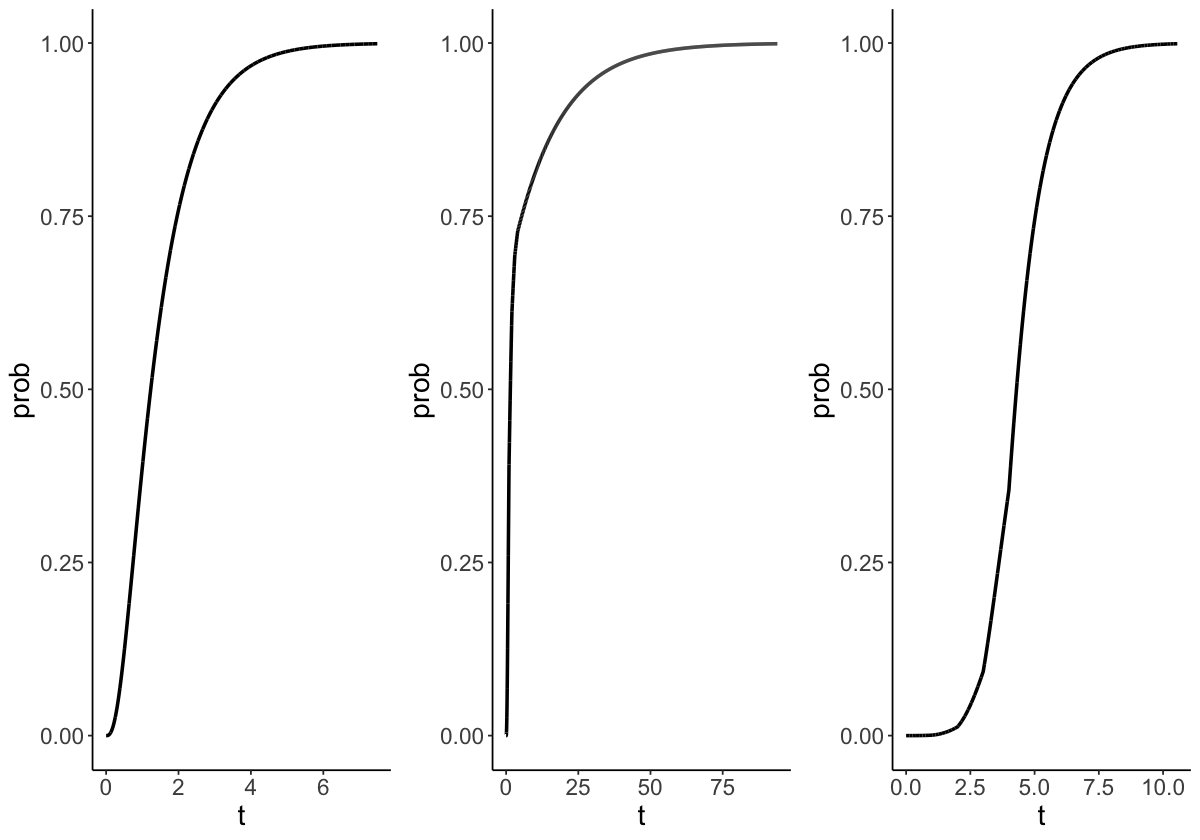

In [67]:
grid.arrange(
    ggplot(cdf1, aes(y=prob, x=t)) + geom_line(linewidth=1) + scale_color_viridis() + despine,
    ggplot(cdf2, aes(y=prob, x=t)) + geom_line(linewidth=1) + scale_color_viridis() + despine,
    ggplot(cdf3, aes(y=prob, x=t)) + geom_line(linewidth=1) + scale_color_viridis() + despine,
 nrow = 1)

In [85]:
sfs_timeinhom <- function(graph, eqopues, sizes) {

    tmrca_pdf <- c()
    time <- c()
    
    ctx <- distribution_context(graph, 1000)
    prev_size <- 0
    while (distribution_context_state(ctx)$cdf < 0.999) { 
        # tmrca_pdf <- c(tmrca_pdf, distribution_context_state(ctx)$pdf)
        # time <- c(time, distribution_context_state(ctx)$time)
        tmrca_pdf[[(length(tmrca_pdf) + 1)]] <- distribution_context_state(ctx)$pdf
        time[[(length(time) + 1)]] <- distribution_context_state(ctx)$time
        
        size <- sizes[findInterval(distribution_context_state(ctx)$time, epoques)]
        if (size != prev_size) {
            graph_update_weights_parameterized(graph, c(1/size))
        }
        prev_size <- size
        distribution_context_step(ctx)
    }
    expected_visits <- distribution_context_accumulated_visiting_time(ctx)
    sfs <- c()
    for (i in 1:(dim(rewards)[1]-1)) {
        sfs <- c(sfs, sum(expected_visits * rewards[i, ]))
    }
    return(sfs)
}

epoques = c(0, 1, 2, 3, 4)
sfs1 <- sfs_timeinhom(graph, epoques, c(1, 1, 1, 1, 1))
sfs2 <- sfs_timeinhom(graph, epoques, c(1, 2, 4, 8, 16))
sfs3 <- sfs_timeinhom(graph, epoques, c(16, 8, 4, 2, 1))

[1] 0.0000000 0.1666667 0.3333333 0.3330004 0.6660008 0.0000000
[1] 0.0000000 0.1671475 0.4131736 1.9283966 3.8567933 0.0000000
[1] 0.0000000 1.5092781 1.3087063 0.5312519 1.0625039 0.0000000


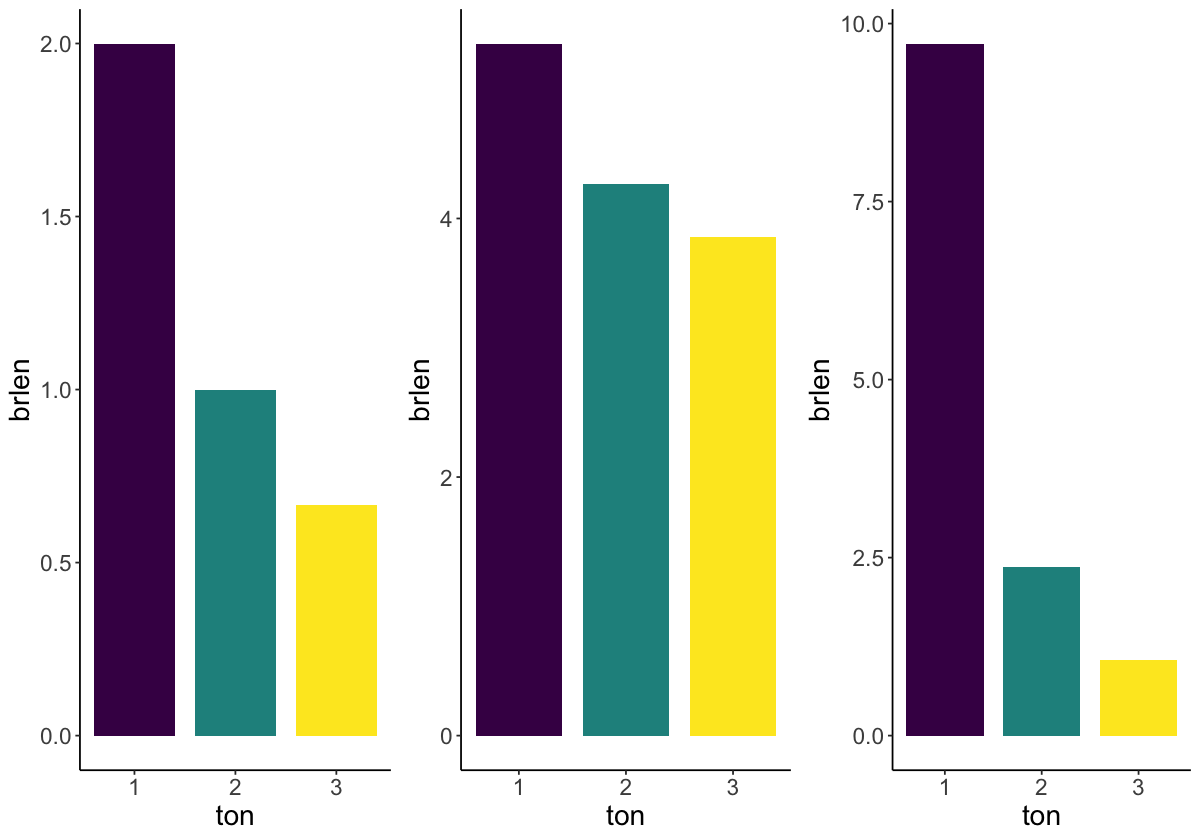

In [55]:
grid.arrange(
    data.frame(
      ton=seq(1,length(sfs1)),  
      brlen=sfs1
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none"),
    data.frame(
      ton=seq(1,length(sfs2)),  
      brlen=sfs2
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none"),
    data.frame(
      ton=seq(1,length(sfs3)),  
      brlen=sfs3
      ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
            geom_bar(stat = "identity", width=0.8) + 
            scale_fill_viridis() + 
            despine + 
            theme(legend.position = "none"), 
    nrow = 1)


# Discrete phase-type distribution

First build representation of the continuous phase-type distribution for the coalescent:

In [56]:
state_vector_length <- n
graph <- create_graph(state_vector_length)
starting_vertex <- vertex_at(graph, 1)
initial_state <- rep(0, n)
initial_state[1] <- n

add_edge(
  starting_vertex,
  create_vertex(graph, initial_state),
  1
)
index <- 2

while (index <= vertices_length(graph)) {
  vertex <- vertex_at(graph, index)
  
  # loop over all classes of lineages
  for (i in 1:n) {
    for (j in i:n) {
      state <- vertex$state
      
      # if same class, there need to be at least two to coalesce
      if (i == j) {
        if (state[i] < 2) {
          next;
        }
        # coal rate
        rate <- state[i] * (state[i] - 1) / 2
      } else {
        # else at least one in each class to coalesce
        if (state[i] < 1 || state[j] < 1) {
          next;
        }
        # number of combinations
        rate <- state[i] * state[j]
      }
      
      # copy state
      child_state <- state
      # update child state
      child_state[i] <- child_state[i] - 1
      child_state[j] <- child_state[j] - 1
      child_state[i+j] <- child_state[i+j] + 1
      
      add_edge(
          vertex,
          find_or_create_vertex(graph, child_state),
          rate
        )
    }
  }
      
  index <- index + 1
}

gam <- graph_as_matrix(graph)
vertices_length(graph)

[1] 6

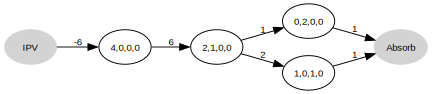

In [57]:
plot_graph(gam)

Then turn it into a descrete phase-type distribution:

In [58]:
make_discrete <- function(mutation_graph, mutation_rate) {
    # Takes a graph for a continuous distribution and turns
    # it into a descrete one (inplace). Returns a matrix of
    # rewards for computing marginal moments

    # current nr of states in graph
    vlength <- vertices_length(mutation_graph)

    # number of fields in state vector (assumes all are the same length)
    state_vector_length <- length(vertex_at(mutation_graph, 1)$state)

    # list state vector fields to reward at each auxiliary node
    rewarded_state_vector_indexes <- vector(mode = "list", length = state_vector_length)

    # loop all but starting node
    for (i in 2:vlength) {
        vertex <- vertex_at(mutation_graph,i)
        if (vertex$rate > 0) { # not absorbing
            for (j in 1:length(vertex$state)) {
                val <- vertex$state[j]
                if (val > 0) { # only ones we may reward
                    # add auxilliary node
                    mutation_vertex <- create_vertex(mutation_graph, rep(0, state_vector_length))
                    add_edge(mutation_vertex, vertex, 1)
                    add_edge(vertex, mutation_vertex, mutation_rate*val)

                    rewarded_state_vector_indexes[[mutation_vertex$index]] <- c(rewarded_state_vector_indexes[[j]], j)
                }
            }
        }
    }
    # normalize graph
    weights_were_multiplied_with <- normalize_graph(mutation_graph)

    # build reward matrix
    rewards <- matrix(nrow=vertices_length(mutation_graph),ncol=state_vector_length, 0)
    for (state in seq_along(rewarded_state_vector_indexes)) {
        for (i in rewarded_state_vector_indexes[[state]]) {
            rewards[state, i] <- 1
        }
    }
    rewards = t(rewards)
    return(rewards)
}

# self-transition rate:
mutation_rate <- 1

# clone graph to get one to modify:
mutation_graph <- clone_graph(graph)

# add auxilliary states, normalize and return reward matrix:
rewards <- make_discrete(mutation_graph, mutation_rate)

# for plotting the new graph
gam <- graph_as_matrix(mutation_graph)

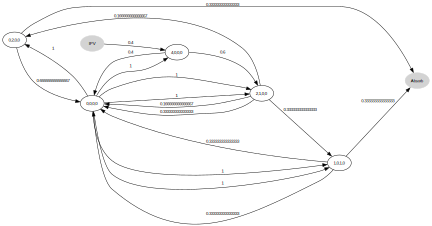

In [59]:
plot_graph(gam)

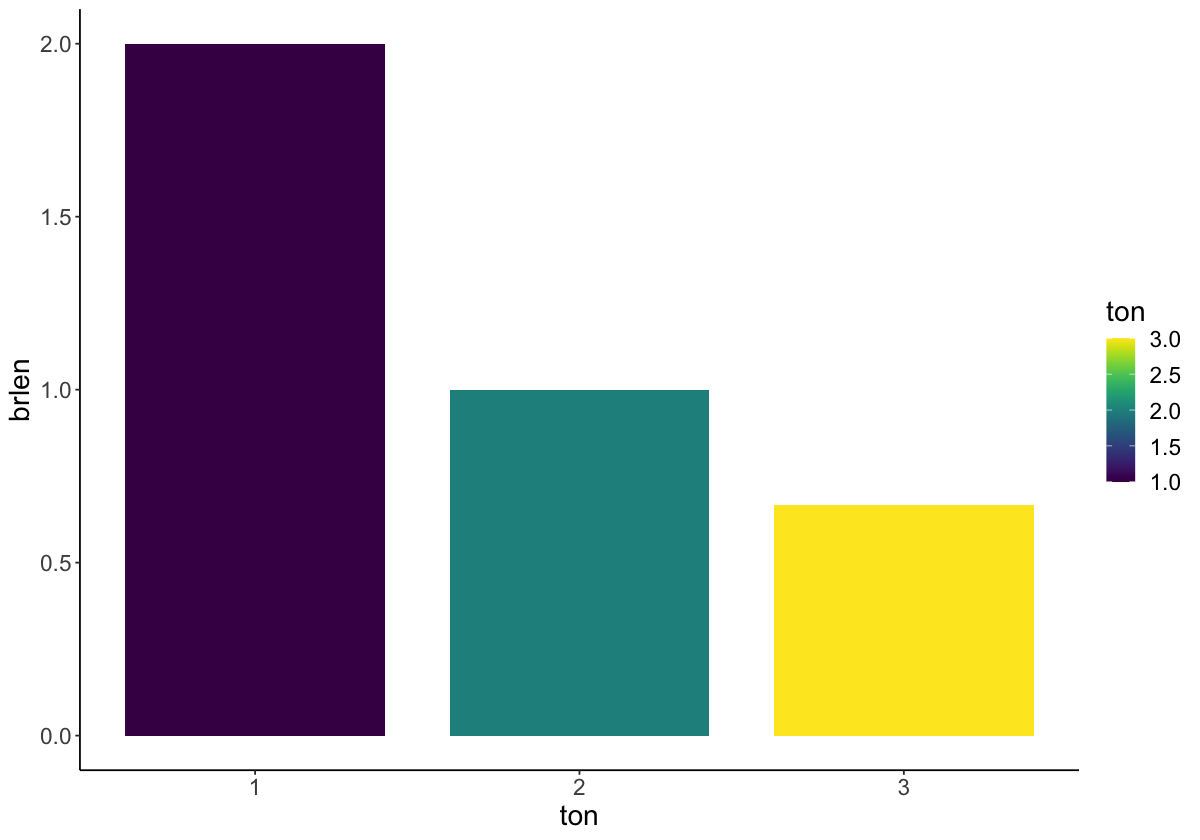

In [60]:
plot_sfs(mutation_graph, rewards)

Covariance:

In [61]:
covariance(mutation_graph, rewards[1,], rewards[2,])

[1] -0.2222222

In [62]:
covariance(mutation_graph, rewards[1,], rewards[3,])

[1] 0.8888889

Covariane between "ton" branch length:

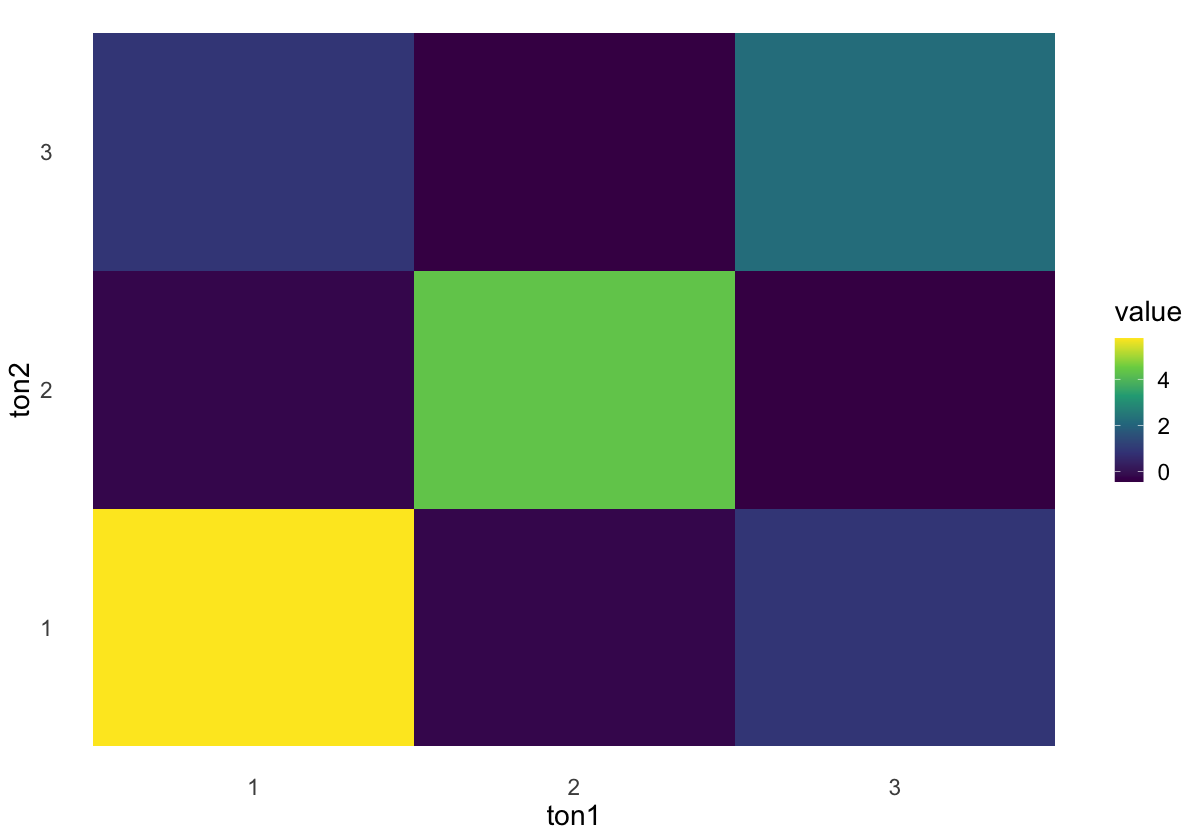

In [63]:
plot_cov_mat(get_cov_mat(mutation_graph, rewards))

In the discrete version, the covariances between tons are the same, but the variance with the same ton between loci (diagonal) is different. The ton variance is much bigger in the discrete version, and the between-locus same-ton variance is almost the same as the ton variance.

Distributions of each "ton":

Notice the difference to the branch length variance above. E.g. in the continuous case the was zero prob of zero singleton branch length, here there no longer zero prob of a no singletons:

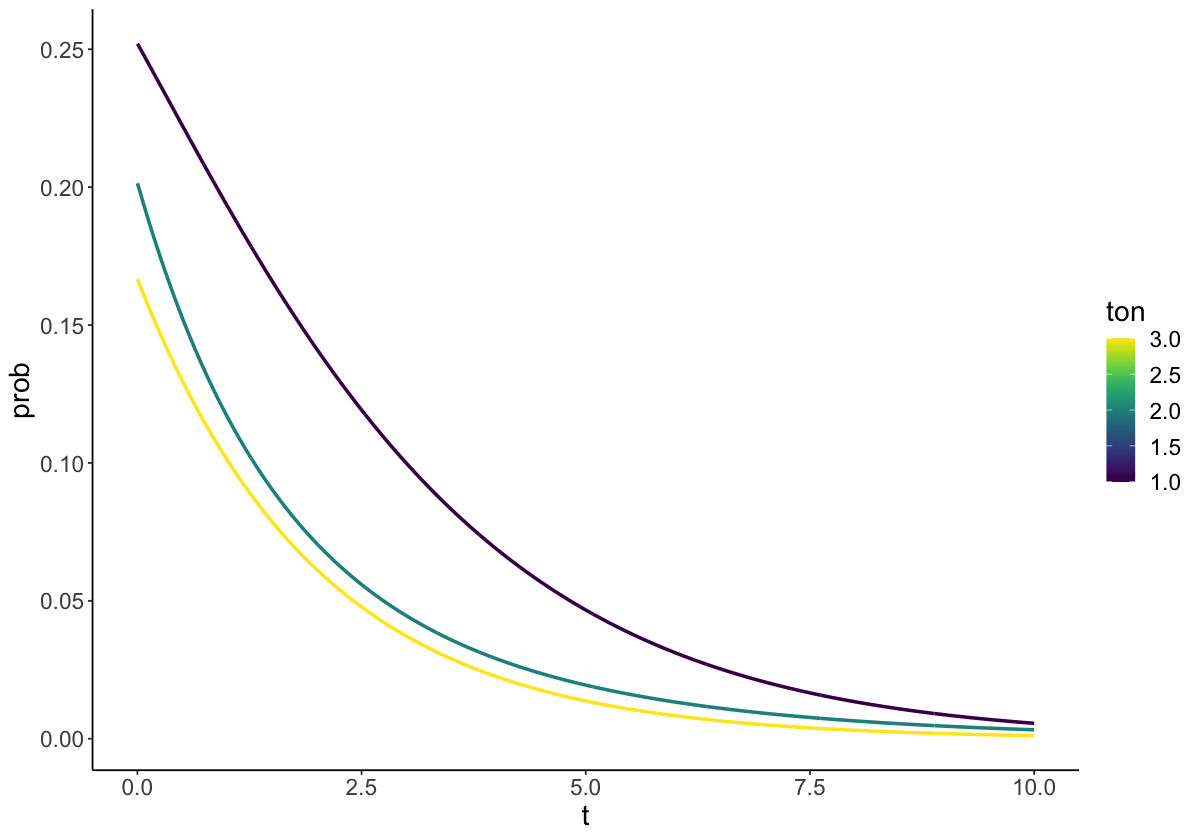

In [64]:
source("plot_functions.R")
plot_sfs_dph(mutation_graph, rewards, trunc=10)

Compute expectations from the distributions:

In [65]:
ctx <- distribution_context(mutation_graph,1000)
prev_size <- 0
while (distribution_context_state(ctx)$cdf < 0.999) { 
    distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)
sfs <- sapply(1:(dim(rewards)[1]-1), function(i) sum(expected_visits * rewards[i,]))
sfs

[1] 1.9991789 0.9991819 0.6658514

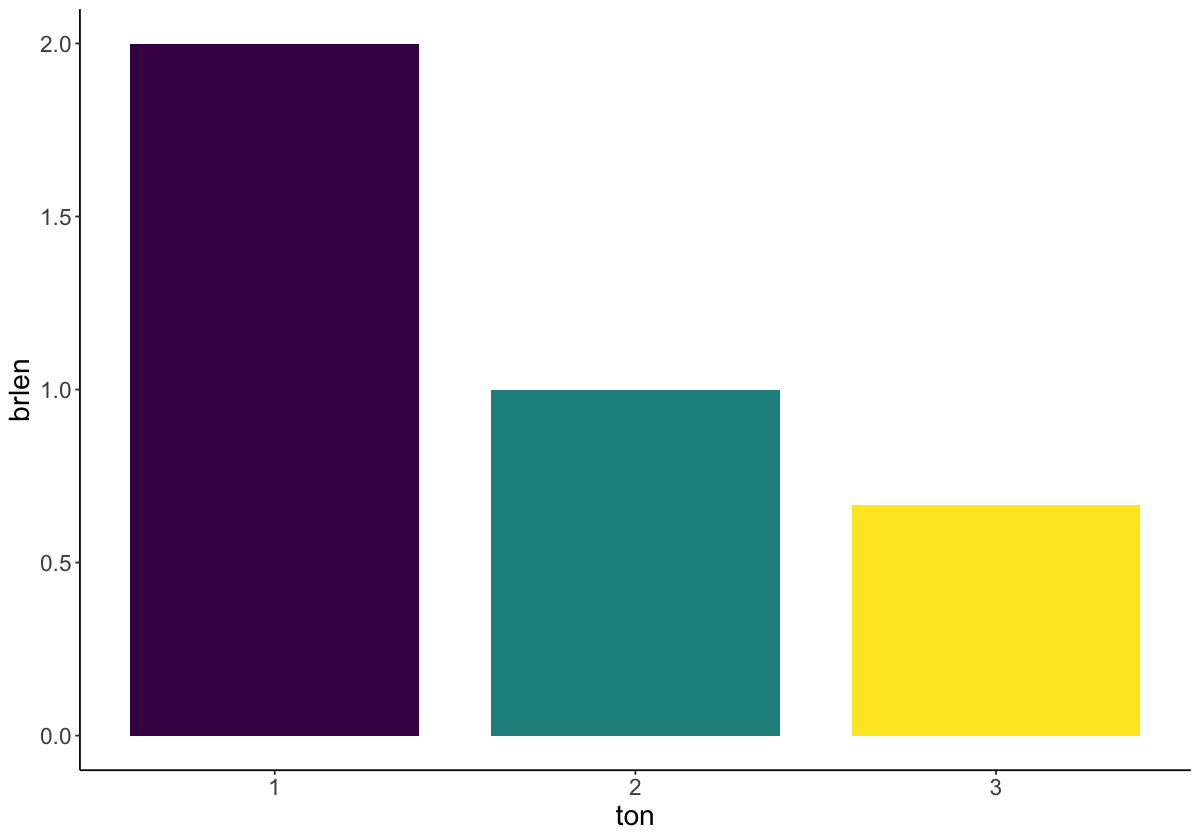

In [66]:
data.frame(
  ton=seq(1,length(sfs)),  
  brlen=sfs
  ) %>% ggplot(aes(y=brlen, x=ton, fill=ton)) + 
        geom_bar(stat = "identity", width=0.8) + 
        scale_fill_viridis() + 
        despine + 
        theme(legend.position = "none")